In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('paper', font_scale=2.2)

In [6]:
sns.set_style('ticks')

In [7]:
import pandas as pd

We generate a random walk with a superdiffusive trajectory for testing. Specifically, we generate one in one-dimension where the steps either move to the left or right with magnitude $x$, where $x$ is given by

$$P(x) = x^{-(\mu + 1)} \frac{\mu (C L)^\mu}{L^\mu - C^\mu}$$

The second moment of this distribution is not well defined (it's technically infinite) for $\mu < 1$, leading to interesteing superdiffusive behaviors.

To generate the walk, we use the below function.

In [13]:
def generate_superdiffusive_trajectory(num_steps, mu, C=0.01, L=10.**6):
    
    rand = np.random.rand(num_steps)
    step_sizes = (rand*(L**(-mu) - C**(-mu)) + C**(-mu))**(-1./mu)

    step_direction = np.random.choice([1, -1], num_steps)
    y_jumps = step_direction*step_sizes
    
    x_jumps = np.ones(num_steps) # Always jump a distance of one

    
    xpos = np.cumsum(x_jumps)
    ypos = np.cumsum(y_jumps)
    
    return xpos, ypos

Simulating many trajectories,

In [14]:
num_steps = 300

In [21]:
xpos_list, ypos_list = [], []

num_trajectories = 300

mu = 2./(4./3.) # Same mu as in kinetic view of statistcal physics
zeta = 2./mu # How we expect the superdiffusive displacement to scale
print 'mu:', mu
print 'zeta:', zeta 

for _ in range(num_trajectories):
    xtemp, ytemp = generate_superdiffusive_trajectory(num_steps, mu, C=0.01, L=10**8)
    xpos_list.append(xtemp)
    ypos_list.append(ytemp)

mu: 1.5
zeta: 1.33333333333


Plotting a couple example trajectories,

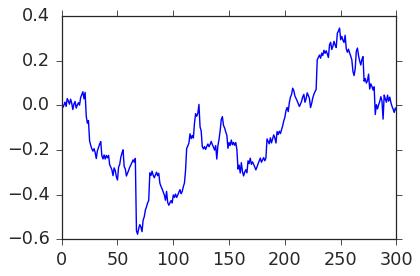

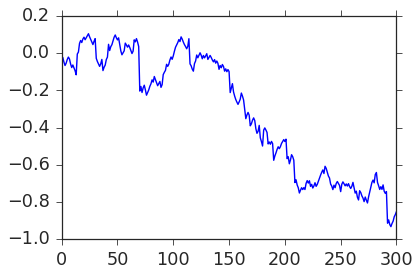

In [22]:
plt.plot(xpos_list[0], ypos_list[0])
plt.figure()
plt.plot(xpos_list[1], ypos_list[1])

The random walk is highly irregular and marked by huge jumps; this is the reason that the second moment is infinite!

In [23]:
import expansion_powerlaw_fit as epfbehavior

In [24]:
import pandas as pd

Applying our powerlaw-extracting technique (the `epf` package) to these traces,

In [26]:
df_list = []

trajectory_num = 0
for cur_x, cur_y in zip(xpos_list, ypos_list):
    
    cur_data = epf.extract_powerlaw_oskar(cur_x, cur_y)
    cur_data = np.asarray(cur_data)
    
    cur_df = pd.DataFrame(data=cur_data, columns=['i', 'window_size', 'mean_msq'])
    cur_df['trajectory'] = trajectory_num
    
    trajectory_num += 1
    
    df_list.append(cur_df)

In [27]:
df = pd.concat(df_list)

I found that looking at the *median* trajectory is quite informative, as the median is well defined although the second moment is not.

In [28]:
trajectory_df = df.groupby(['trajectory', 'window_size']).agg(np.median).reset_index()

If we take the median displacement of each trace over each window,

(1e-05, 10.0)

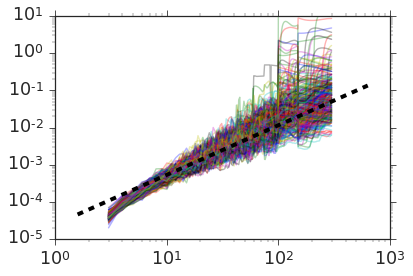

In [38]:
for name, cur_data in trajectory_df.groupby(['trajectory']):
    plt.loglog(cur_data['window_size'], cur_data['mean_msq'], alpha=0.3)
    
xtest = np.logspace(0.2, 2.8)
plt.loglog(xtest, 2.5e-5*xtest**(zeta), color='black', ls='--', lw=4)

plt.ylim(1e-5, 1e1)

Indeed, the median behavior scales the way we expect.

If we now take the median over every window interval over the trace of every random walk,

In [39]:
median_df = df.groupby(['window_size']).agg(np.median).reset_index()

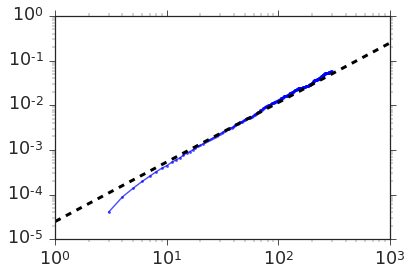

In [45]:
x = np.array(median_df['window_size'].values, dtype = np.double)
y = median_df['mean_msq']

plt.loglog(x, y, ls='-', marker='.', alpha=0.7)
xtest = np.linspace(1, 1000)
plt.plot(xtest, 2.5e-5*xtest**(zeta), ls='--', color='black', lw=3)

Indeed at large number of steps, the distribution scales how we expect! We can change $\mu$ and get different scaling behavior too (we always get what we expect, in this case).